In [1]:
import collections

import pandas as pd

from gnn_tracking.utils.graph_masks import edge_subgraph
from gnn_tracking_hpo.trainable import PretrainedECTCNTrainable
import torch
from gnn_tracking.postprocessing.dbscanscanner import dbscan
import matplotlib.pyplot as plt
import numpy as np


plt.style.use('sss1.mplstyle')

%load_ext autoreload
%autoreload 1

In [2]:
trainable = PretrainedECTCNTrainable.reinstate("2cd19772_tcn", "e56780ec", config_override={"n_graphs_train": 1, "n_graphs_val": 10, "n_graphs_test": 1})

[17:12:08 HPO] DEBUG: Loading config from /home/kl5675/ray_results/2cd19772_tcn/PretrainedECTCNTrainable_e56780ec_7_val_batch_size=1,adam_amsgrad=False,adam_beta1=0.9000,adam_beta2=0.9990,adam_eps=0.0000,adam_w_2023-05-16_13-38-33/params.json
[17:12:08 HPO] INFO: I'm running on a node with job ID=47891798
[17:12:08 HPO] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[17:12:08 HPO] INFO: The ID of my dispatcher is 0
[17:12:08 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[17:12:08 HPO] DEBUG: Got config
┌───────────────────────────────┬──────────────────────────────────────────┐
│ _val_batch_size               │ 1                                        │
│ adam_amsgrad                  │ False                                    │
│ adam_beta1                    │ 0.9                                      │
│ adam_beta2                    │ 0.999                                    │


In [67]:
trainer = trainable.trainer
trainer.model.eval()
sel = 5
with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        if idx == sel:
            break

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/s

In [68]:

import networkx as nx

In [69]:
import torch_geometric

In [70]:
import enum
import typing
import itertools
import collections
from typing import Iterable

def shortest_path_length_catch_no_path(graph: nx.Graph, source, target) -> int|float:
    """Same as nx.shortest_path_length but retun inf if no path exists"""
    try:
        return nx.shortest_path_length(graph, source=source, target=target)
    except nx.NetworkXNoPath:
        return float('inf')


def shortest_path_length_multi(graph: nx.Graph, sources: Iterable[int], targets: Iterable[int]):
    """Shortest path for source to reach any of targets from any of the sources.
    If no connection exists, returns inf. If only target is source itself, returns 0.
    """
    if set(sources) == set(targets):
        return 0
    targets = set(targets) - set(sources)
    return min([shortest_path_length_catch_no_path(graph, source=source, target=target) for source, target in itertools.product(sources, targets)])

from enum import auto

class TrackCategory(enum.Enum):
    PERFECT = auto()
    MAJORITY = auto()




class TrackInfo(typing.NamedTuple):
    pid: int
    n_hits: int
    n_segments: int
    n_hits_largest_segment: int
    distance_largest_segments: int
    biggest_component: int


def get_n_reachable(graph: nx.Graph, source: int, targets: typing.Sequence[int]) -> int:
    targets = set(targets) - {source}
    return sum([nx.has_path(graph, source=source, target=target) for target in targets])


def get_track_info(graph: nx.Graph, data, pid):
    hits_for_pid = np.where(data.particle_id == pid)[0]
    sg = graph.subgraph(hits_for_pid).to_undirected()
    segments = sorted(nx.connected_components(sg), key=len, reverse=True)
    biggest_component = 1+max(
        get_n_reachable(graph, hit, hits_for_pid) for hit in hits_for_pid
    )
    distance_largest_segments = 0
    if len(segments) > 1:
        distance_largest_segments = shortest_path_length_multi(graph, sources=segments[0], targets=segments[1])
    return TrackInfo(
        pid = pid.item(),
        n_hits = len(hits_for_pid),
        n_segments = len(segments),
        n_hits_largest_segment = len(segments[0]),
        distance_largest_segments = distance_largest_segments,
        biggest_component = biggest_component,
    )

In [71]:
def get_track_info_df(data, model, pt_thld=0.9, threshold=None):
    if threshold is None:
        threshold = model._gtcn.threshold
    edge_mask = (model._gtcn.ec(data)["W"] > threshold).squeeze()
    gx = torch_geometric.utils.convert.to_networkx(edge_subgraph(data, edge_mask))
    particle_ids = data.particle_id[(data.particle_id > 0) & (data.pt > pt_thld)].unique()
    results = []
    for pid in particle_ids:
        results.append(get_track_info(gx, data, pid))
    return pd.DataFrame(results, columns=["pid", "n_hits", "n_segments", "n_hits_largest_segment", "distance_largest_segments", "biggest_component"])

In [72]:
trainer.model.eval()
with torch.no_grad():
    w = trainer.model._gtcn.ec(data)["W"]

In [73]:
data.y.shape

torch.Size([145106])

In [74]:
from tqdm import tqdm

thresholds = np.linspace(0., 1., 30)
tpr = []
fpr = []
for threshold in tqdm(thresholds):
    passes = w>= threshold
    true = data.y == 1
    tp = ((passes) & true).sum()
    fp = ((passes) & (~true)).sum()
    tpr.append(tp.sum().item() / sum(true))
    fpr.append(fp.sum().item() / sum(~true))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:02<00:00,  2.08s/it]


In [75]:
dfs = []

for threshold in tqdm(thresholds):
    df = get_track_info_df(data, trainer.model, threshold=threshold)
    dfs.append(df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:24<00:00,  1.21it/s]


In [76]:
frac_perfect = []
frac_goods = []
frac_possible = []
frac_goods75 = []
frac_possible75 = []

for df in dfs:
    frac_perfect.append(sum((df.n_hits_largest_segment / df.n_hits) == 1) / len(df))
    frac_goods.append(sum((df.n_hits_largest_segment / df.n_hits) >= 0.50) / len(df))
    frac_possible.append(sum((df.biggest_component / df.n_hits) >= 0.50) / len(df))
    frac_goods75.append(sum((df.n_hits_largest_segment / df.n_hits) >= 0.75) / len(df))
    frac_possible75.append(sum((df.biggest_component / df.n_hits) >= 0.75) / len(df))

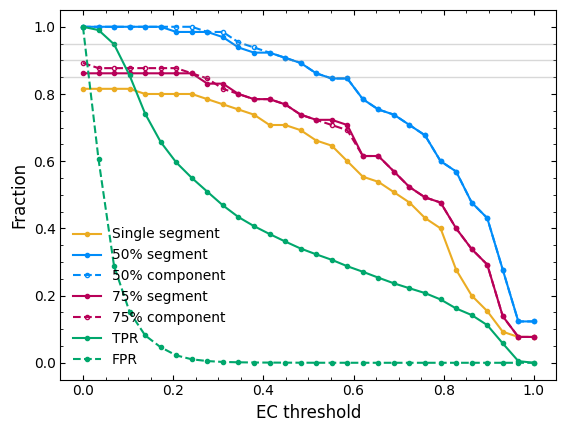

In [78]:
# %matplotlib notebook
fig, ax = plt.subplots()
markup = dict(marker=".")
ax.plot(thresholds, frac_perfect, **markup, label="Single segment", c="C0")
ax.plot(thresholds, frac_goods, **markup, label="50% segment", c="C2")
ax.plot(thresholds, frac_possible, **markup, label="50% component", ls="--", c="C2", markerfacecolor="none")
ax.plot(thresholds, frac_goods75, **markup, label="75% segment", c="C1")
ax.plot(thresholds, frac_possible75, **markup, label="75% component", ls="--", c="C1", markerfacecolor="none")
ax.plot(thresholds, tpr, c="C3", label="TPR", **markup)
ax.plot(thresholds, fpr, c="C3", label="FPR", ls="--", **markup)
ax.set_ylabel("Fraction")
ax.set_xlabel("EC threshold")
ax.axhline(0.9, c="gray", alpha=0.3, lw=1)
ax.axhline(0.95, c="gray", alpha=0.3, lw=1)
ax.axhline(0.85, c="gray", alpha=0.3, lw=1)

ax.legend()

In [12]:
len(data.particle_id)

2423

Unconnected
Connected
n-hop-connected

In [84]:
x = model_output["x"]
pid = model_output["particle_id"]
pt = model_output["pt"]
labels = dbscan(x)

xs = np.stack((x[:, 0], x[:, 1])).T


In [85]:
sorted(model_output.keys())

['beta',
 'ec_edge_mask',
 'ec_hit_mask',
 'edge_index',
 'node_features',
 'particle_id',
 'pred',
 'pt',
 'reconstructable',
 'sector',
 'track_params',
 'w',
 'x',
 'y']

In [86]:

%aimport gnn_tracking
%aimport gnn_tracking.plotting
%aimport gnn_tracking.plotting.latent
import gnn_tracking
import gnn_tracking.plotting
import gnn_tracking.plotting.latent
from gnn_tracking.plotting.latent import SelectedPidsPlot


In [90]:
random_pids = np.random.choice(pid[(pid > 0) & (pt > 0.9)], 7, replace=False)

In [91]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(xs)

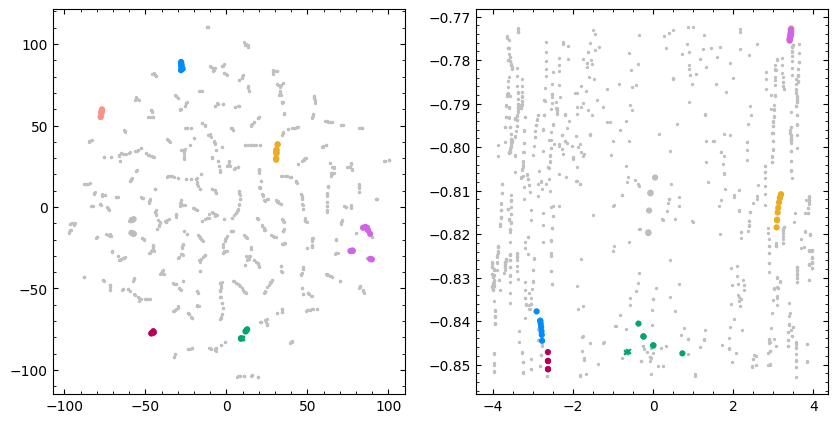

In [93]:
spp = SelectedPidsPlot(x_tsne, pid, data=data, labels=labels, ec_hit_mask=model_output["ec_hit_mask"], selected_pids=random_pids)
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
spp.plot_other_hit_latent(axs[0])
spp.plot_selected_pid_latent(axs[0])
spp.plot_collateral_latent(axs[0])
spp.plot_other_hit_ep(axs[1])
spp.plot_selected_pid_ep(axs[1])
spp.plot_collateral_ep(axs[1])